# H2O: Confronto FCI e VQE con PUCCD

In [86]:
import numpy as np
import matplotlib.pyplot as plt

In [87]:
# from subroutines import *

# Array distanze e energie
arr_distance = np.arange(0.40, 2.05, 0.15) # (0.40, 2.05, 0.15) con 5 orbitali attivi
arr_ground_energy = {
    'FCI': [],
    'pUCCD': []
}


## 1 - Algoritmo classico

### 1.1 - FCI

FCI su H2O per comparazione.

In [88]:
from pyscf import gto, scf, fci
import math

basis = 'sto-3g'

for distance in arr_distance:
    # nell'articolo fissano l'angolo a 109.57° (invece di 104.5°)
    bond_angle = 109.57
    h = math.tan(bond_angle/2) * distance/2
    geometry = "H .0 .0 .0; O .0 " + str(h) + " " + str(distance) + "; H .0 .0 " + str(distance)
    
    mol = gto.M(
        atom=geometry,
        charge=0,
        spin=0,
        basis=basis,
        symmetry=True,
        verbose=0
    )
    # per ciascuna molecola calcolo il campo medio con restricted HF 
    cm  = scf.RHF(mol) # campo medio
    e_HF = cm.kernel() # questo va runnato a prescindere
    
    # per ciascuna molecola calcolo FCI
    fci_calc = fci.FCI(cm) # <- nei metodi correlati passiamo come argomento un conto di campo medio, HF
    e_FCI = fci_calc.kernel()[0]
    arr_ground_energy['FCI'].append(e_FCI)


## 2 - VQE: pUCCD

Spezzetto il problema:
1. dichiarazione del problema
1. costruzione dell'ansatz
1. risoluzione

In [89]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer

# dichiarazione del problema
def generate_H2O_problem (distance: float = .0, basis: str = 'sto-3g', reduce: bool = False):
    # nell'articolo fissano l'angolo a 109.57° (invece di 104.5°)
    bond_angle = 109.57
    h = math.tan(bond_angle/2) * distance/2
    H2O = "H .0 .0 .0; O .0 " + str(h) + " " + str(distance) + "; H .0 .0 " + str(distance)

    driver = PySCFDriver(
        atom=H2O,
        basis=basis, 
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )    
    
    problem = driver.run()
    
    if reduce:
        # riduco il problema, estraendo uno stato iniziale HF dal problema ridotto da usare come initial_state
        # 1s (2e-) di O in freeze. Restano 6 e- in 3 orbitali pieni e 2 vuoti
        # per ora provo 5 orbitali attivi
        transformer = ActiveSpaceTransformer(num_electrons=(3,3), num_spatial_orbitals=5, active_orbitals=[1,2,3,4,5]) 
        problem = transformer.transform(problem)
        
    return problem

In [90]:
from qiskit_nature.second_q.circuit.library import HartreeFock, PUCCD
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper

#mapper = JordanWignerMapper()
mapper = ParityMapper()

# costruzione dell'ansatz
def generate_ansatz ( problem, mapper = mapper ):
    
    ansatz = PUCCD(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )
    
    return ansatz

In [91]:
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator 
# Estimator was deprecated, warnings suggest to use StatevectorEstimator instead

from qiskit_nature.second_q.algorithms import GroundStateEigensolver
    
# risoluzione
def solve_problem (problem, ansatz, mapper = mapper):

    vqe_solver = VQE( Estimator(), ansatz, SLSQP() ) #, callback=store_intermediate_result)
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters
    
    calc = GroundStateEigensolver(mapper, vqe_solver)

    res = calc.solve(problem)
    
    return res

Metto tutto insieme

In [92]:
from qiskit_algorithms import NumPyMinimumEigensolver

# Esecuzione algoritmo

for distance in arr_distance:
    
    # Problema da Driver della molecola 
    problem = generate_H2O_problem (distance, reduce=True)
    # Ansatz da problema con mapper default (JW)
    ansatz = generate_ansatz (problem)
    
    # Soluzione con VQE
    result = solve_problem (problem, ansatz)
    
    # Estraggo l'energia del sistema
    computed_part = result.groundenergy
    active_space_energy_part = result.extracted_transformer_energies.get("ActiveSpaceTransformer", 0)
    nuclear_repulsion_energy = result.nuclear_repulsion_energy
    total_ground_energy = computed_part + active_space_energy_part + nuclear_repulsion_energy
    
    arr_ground_energy['pUCCD'].append(total_ground_energy)

/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_39170/3486939009.py:11: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, SLSQP() ) #, callback=store_intermediate_result)


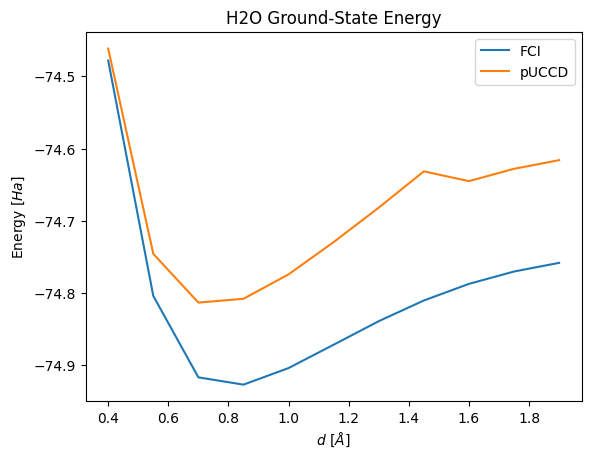

In [93]:
# Plot
method = ['FCI', 'pUCCD']

for met in method:  
    plt.plot(arr_distance, arr_ground_energy[met], label=met)

plt.title("H2O Ground-State Energy")
plt.xlabel(r"$d$ $[\AA]$")
plt.ylabel(r"Energy $[Ha]$")
plt.legend()
plt.show()

## 3 - VQE: oo-pUCCD